In [2]:
import numpy as np
from matplotlib import pyplot as plt
import math
from dataclasses import dataclass
from functools import cache
from typing import Optional, List
from sortedcontainers import SortedDict

In [62]:
N = 5
dt = 0.01
tmax = 1

In [78]:
class Particle:
    """
    A particle in a one-dimensional electrostatic cold stream plasma.

    Attributes:
    -----------
    id : int
        Label to preserve order of particles
    alpha : float
        The Lagrangian coordinate of the particle, ranging from 1:N
    x : float
        The position of the particle in the domain [0,1).
    v : float
        The velocity of the particle.
    """
    id: int
    alpha: float
    x: float
    v: float

    def __init__(self, id_in: int, N: int, epsilon: float):
        """
        Initialize the particle with a given position and set all other attributes to zero.
        
        Parameters:
        -----------
        id_in : int
            The ID of the particle.
        N_in : int
            The total number of particles.
        epsilon : magnitude of disruption
        """
        self.id = id_in
        self.alpha = (self.id - 0.5) / N
        self.x = self.alpha + epsilon*math.sin(2* math.pi * self.alpha)
        self.v = 0.0
        self.pos_hist = [self.x]
        self.vel_hist = [self.v]

    def __lt__(self, other):
        """
        Compare two particles with respect to their Lagrangian Coordinates

        Parameters:
        -----------
        other : Particle
            The other particle that the current one will be compared to

        """
        return self.alpha < other.alpha


    def update_position(self, dt):
        """
        Update the position of the particle based on its current velocity and the
        elapsed time using Euler's Method.
        
        Args:
            dt (float): The elapsed time in seconds.
        
        Returns:
            None
        """
        self.x = (self.x + self.v * dt) % 1
        self.pos_hist.append(self.x)


    def update_velocity(self, acceleration):
        """
        Update the velocity of the particle based on the given acceleration and
        the elapsed time using Euler's Method.
        
        Args:
            acceleration (float): The acceleration of the particle.
            dt (float): The elapsed time in seconds.
        
        Returns:
            None
        """
        self.v += acceleration(self) * dt
        self.vel_hist.append(self.v)



In [84]:
class Plasma_Evolver:

    N: int
    dt: float
    epsilon: float
    ion_density: float = 1
    plasma : SortedDict
    t: float = 0
    kernel: callable
    
    def __init__(self, N_in: int, dt_in: float, kernel_in: callable, epsilon_in: float = 0.05):
        """
        Initializes Plasma_Evolver class, setting parameters and initializing the plasma in
        a Sorted Dict

        Args:
        - N_in (int): The number of particles to generate.
        - dt_in (float): Simulation timestep
        - epsilon (float): Magnitude of the perturbation. Defaults to 0.05.

        """
        self.N = N_in
        self.dt = dt_in
        self.kernel = kernel_in
        self.epsilon = epsilon_in
        self.plasma = SortedDict()

        for i in range(1, self.N+1):
            p = Particle(i, self.N, epsilon=self.epsilon)
            self.plasma[p.id] = p


    def calc_acceleration(self, p: Particle):

        sum_k = 0
        sum_x = 0

        for q in self.plasma.values():
            sum_k -= self.kernel(p, q)
            sum_x += q.x

        sum_k = sum_k / self.N
        sum_x = sum_x / self.N

        return sum_k + self.ion_density*(p.x - 0.5) - (sum_x - 0.5)
    
    
    def evolve_plasma(self, time: float):

        for i in range(int(time / self.dt)):
            for p in self.plasma.values():
                p.update_velocity(self.calc_acceleration)
                p.update_position(dt)

    def plot_particles(self, zoom: bool = False):
        """
        Plots particles stored in a sorted dictionary in phase space as points where
        the x-coordinate is position and the y-coordinate is velocity, and lines that 
        connect neighboring particles on the sorted dictionary.
        
        Args:
        - zoom (bool): boolean to zoom in into the center.
        
        Returns:
        - None
        """
        
        # Extract positions and velocities of particles
        positions = [p.x for p in self.plasma.values()]
        velocities = [p.v for p in self.plasma.values()]
        
        # Plot particles as points in phase space
        fig, ax = plt.subplots(figsize=(8,6))
        #ax.scatter(positions, velocities)
        ax.set_xlabel('Position')
        ax.set_ylabel('Velocity')
        ax.set_title('Phase space plot of particles')
        ax.set_xlim((0,1))
        ax.set_ylim((-1,1))

        if zoom:
            ax.set_xlim((0.4, 0.6))
            ax.set_ylim((-0.2, 0.2))
        
        # Add lines connecting neighboring particles on the sorted dictionary
        for i, (k, p) in enumerate(self.plasma.items()):
            if i == 0:
                continue
            prev_p = list(self.plasma.values())[i-1]
            ax.plot([prev_p.x, p.x], [prev_p.v, p.v], color='black', alpha=0.3)

In [60]:
def k(p1: Particle, p2: Particle) -> float:
    diff = p1.x - p2.x
    if (diff > 0):
        return 0.5 
    elif diff < 0:
        return -0.5
    return 0



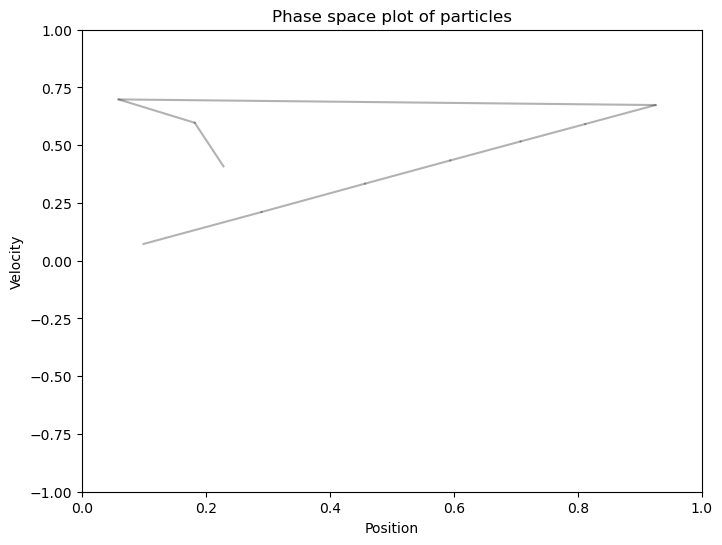

In [85]:
driver = Plasma_Evolver(10, 0.01, k)

driver.evolve_plasma(1)
driver.plot_particles()

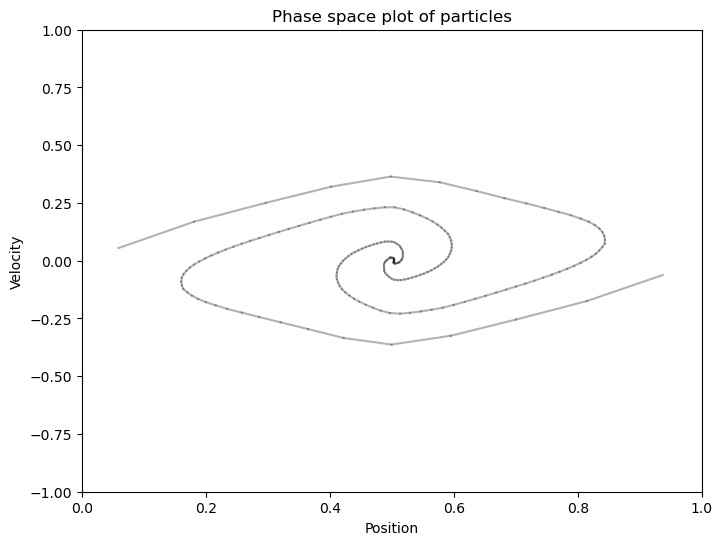

In [76]:
tmax = 5
N = 200

plasma = generate_starting_stream(N)

for i in range(int(tmax / dt)):
    for p in plasma.values():
        p.update_velocity(calc_acceleration, plasma, dt)
        p.update_position(dt)


plot_particles(plasma)

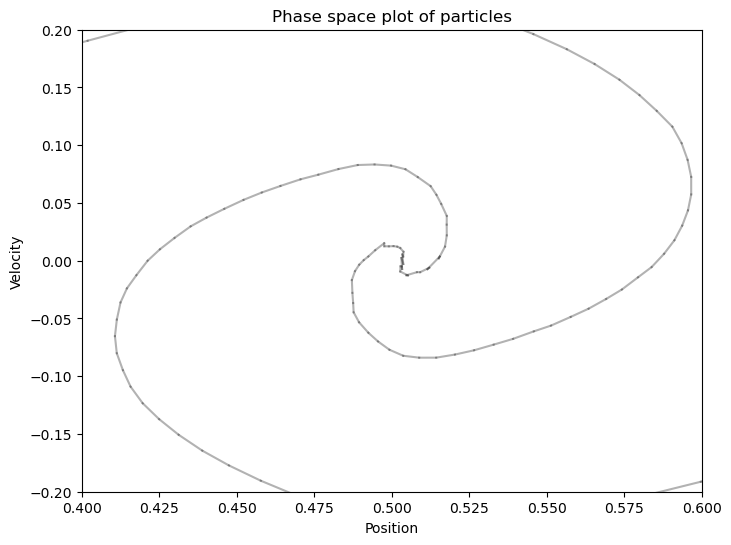

In [77]:
plot_particles(plasma, zoom=True)